In [2]:
!pip install torchsummary

In [3]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader, random_split # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
from tqdm import tqdm
import time
from torchvision import models

# For Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sn

In [4]:
%matplotlib inline

In [5]:
data_dir = "../input/plantvillagecolor/color"
# data_dir = "/content/drive/MyDrive/COMP6721-Project/PlantVillage-Dataset"

diseases = os.listdir(data_dir)

In [6]:
# printing the disease names
print(diseases)
print("Total disease classes are: {}".format(len(diseases)))

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [7]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [8]:
# Unique plants in the dataset
print("Number of plants: {}".format(len(plants)))
print(f"Unique Plants are: ")
for idx, plant in enumerate(plants):
  print(str(idx + 1) + '. ' + plant)


Number of plants: 14
Unique Plants are: 
1. Tomato
2. Grape
3. Orange
4. Soybean
5. Squash
6. Potato
7. Corn_(maize)
8. Strawberry
9. Peach
10. Apple
11. Blueberry
12. Cherry_(including_sour)
13. Pepper,_bell
14. Raspberry


In [9]:
# number of unique diseases
print("Total number of diseases: {}".format(NumberOfDiseases))


Total number of diseases: 26


In [10]:
# Number of images for each disease
disease_class_size = {}
for disease in diseases:
    disease_class_size[disease] = len(os.listdir(data_dir + '/' + disease))
    
# converting the disease_class_size dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(disease_class_size.values(), index=disease_class_size.keys(), columns=["no. of images"])
img_per_class

,no. of images
Tomato___Late_blight,1909
Tomato___healthy,1591
Grape___healthy,423
Orange___Haunglongbing_(Citrus_greening),5507
Soybean___healthy,5090
Squash___Powdery_mildew,1835
Potato___healthy,152
Corn_(maize)___Northern_Leaf_Blight,985
Tomato___Early_blight,1000
Tomato___Septoria_leaf_spot,1771


Text(0.5, 1.0, 'Images per each class of plant disease')

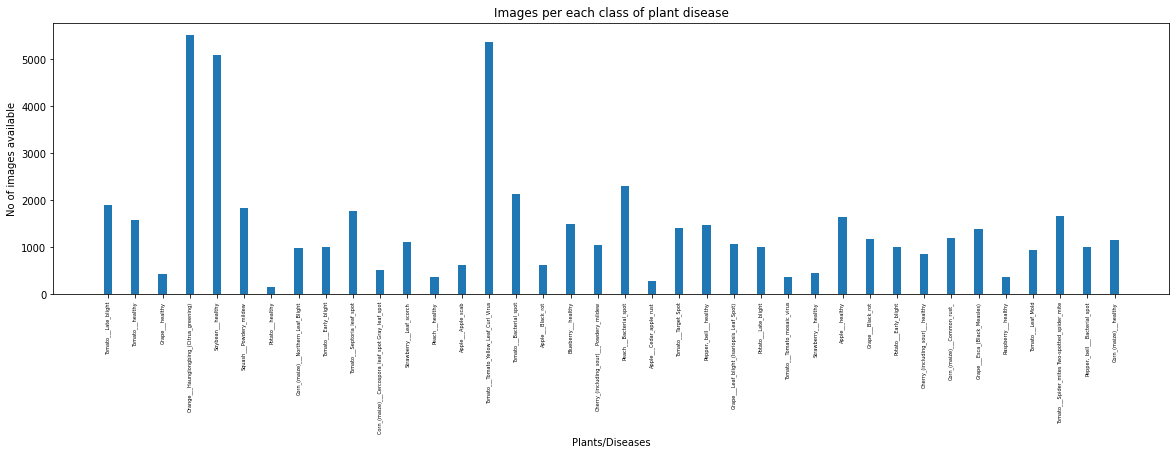

In [11]:
# plotting number of images available for each disease
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in disease_class_size.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

In [12]:
## Split Train, Test and Validation ##

def get_files_from_folder(path):
    files = os.listdir(path)
    return np.asarray(files)

get_files_from_folder(data_dir)

def load_data(path, validation_split, test_split, batch_size):
    transform_dict = {
        "src": transforms.Compose([
            # transforms.Resize(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.225, 0.225, 0.225]),
            #transforms.Resize(224)
        ])
    }
    
    dataset = ImageFolder(root=path, transform=transform_dict["src"])
    
    dataset_size = len(dataset)
    validation_size = int(validation_split * dataset_size)
    test_size = int(test_split * dataset_size)
    train_size = dataset_size - (test_size + validation_size)

    # TODO: Split classes into equal sizes?!
    train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
    
    return train_dataset, validation_dataset, test_dataset

In [13]:
train_dataset, validation_dataset, test_dataset = load_data(data_dir, 0.1, 0.2, 200)

In [14]:
img, label = train_dataset[0]

print(img.shape, label)

torch.Size([3, 256, 256]) 3


In [15]:
# TODO: Correct it

print(f"There are {len(train_dataset) + len(validation_dataset) + len(test_dataset)} images in total")

print(f"There are {len(train_dataset)} images for training")

print(f"There are {len(validation_dataset)} images for validation")

print(f"There are {len(test_dataset)} images for testing")

There are 54305 images in total
There are 38014 images for training
There are 5430 images for validation
There are 10861 images for testing


In [16]:
# for checking some images from training dataset
def show_image(image, label):
    # print("Label :" + train_dataset.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

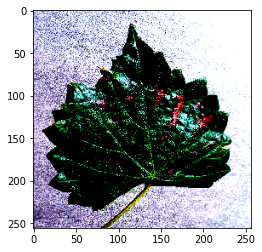

In [17]:
show_image(*train_dataset[21])

In [18]:
# Setting the seed value
random_seed = 7
a = torch.manual_seed(random_seed)


In [19]:
# setting the batch size
batch_size = 32

# Load data to DataLoaders for training, validation and test
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_dataloader = DataLoader(validation_dataset, batch_size, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

In [20]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

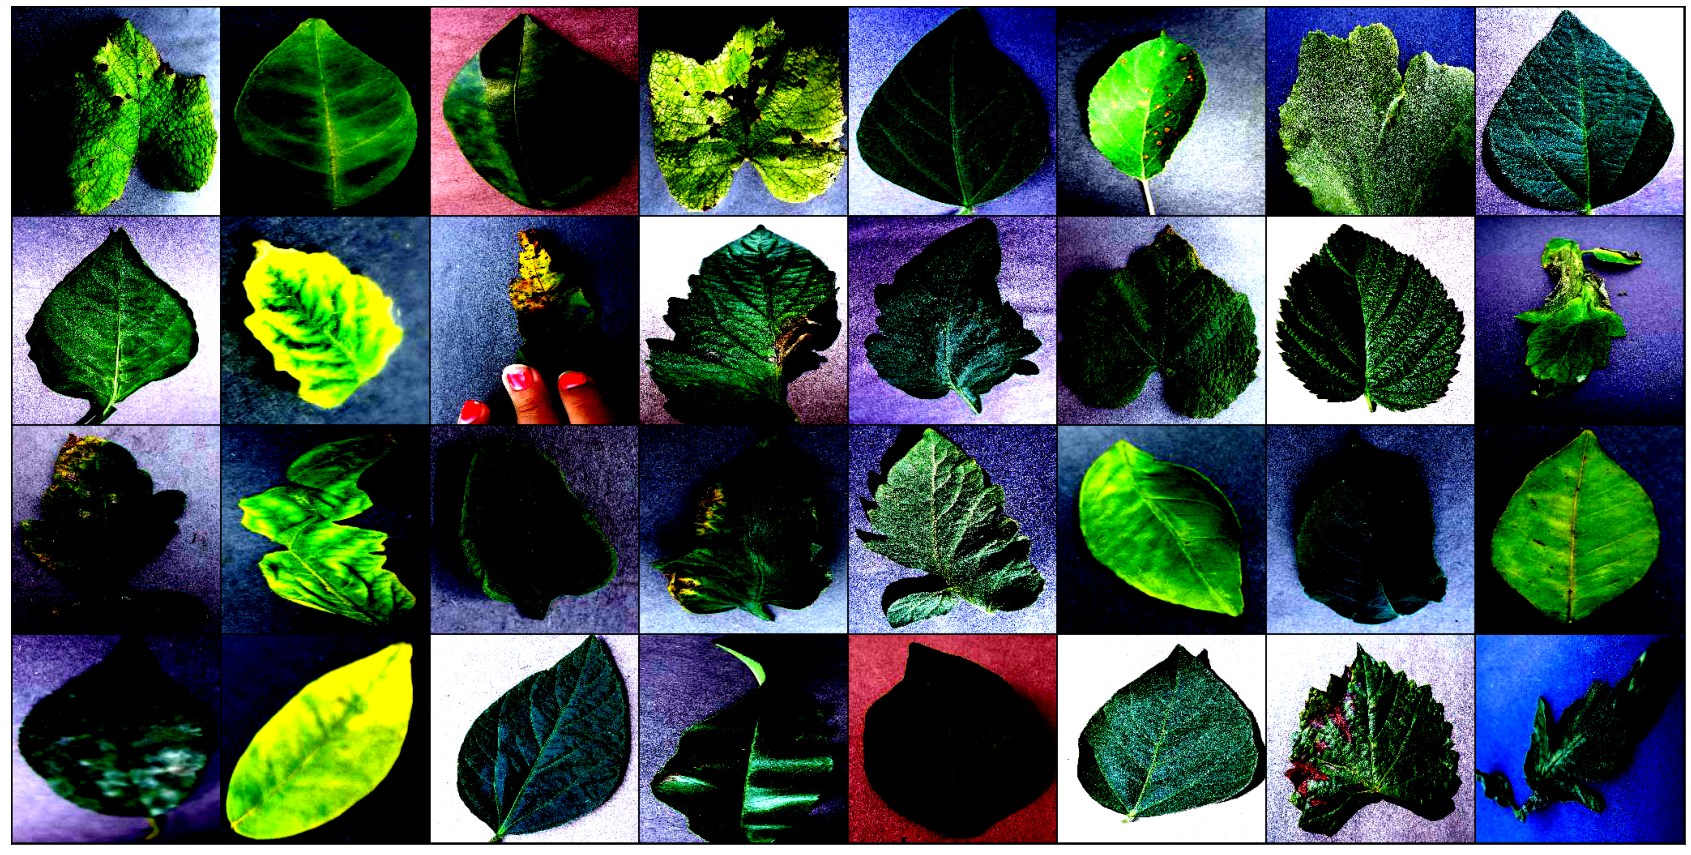

In [21]:
show_batch(train_dataloader)

In [22]:
# TODO: Remove. get_default_device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

cuda:0


In [23]:
# Moving data into GPU
train_dataloader = DeviceDataLoader(train_dataloader, device)
validation_dataloader = DeviceDataLoader(validation_dataloader, device)

In [24]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [25]:
#model definition
def getModel():
    model = None
    model = models.resnet50(pretrained=False)
    model.fc = nn.Linear(in_features=2048, out_features=len(train_dataset.dataset.classes))
    return model

In [28]:
#definition of training loop
def train(num_epochs, model, train_dataloader, validation_dataloader, loss_fn, optimizer):
    print(batch_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: {}".format(device))
    model.to(device)

    accuracy_validation = []
    accuracy_train = []
    loss_validation = []
    loss_train = []


    num_epochs = num_epochs
    total_steps = len(train_dataloader)
    t1 = time.time()
    
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        mean_loss = 0
        for i, data in enumerate(train_dataloader):
            #print(i)
            images, labels = data[0].to(device), data[1].to(device)
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            # Backprop and optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Train accuracy
            total += labels.size(0)
            _,predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            mean_loss +=loss.item()
            
        accuracy_train.append((correct/total) * 100)
        loss_train.append(mean_loss/len(train_dataloader))
        print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                    .format(epoch + 1, num_epochs, mean_loss/len(train_dataloader),
                        (correct / total) * 100))

        model.eval()
        with torch.no_grad():
            correct_validation_labels = 0
            total_validation_labels = 0

            for validation_data in validation_dataloader:
                validation_images, validation_labels = validation_data[0].to(device), validation_data[1].to(device)
                predicted_outputs = model(validation_images)

                _, validation_prediction = torch.max(predicted_outputs.data, 1)
                total_validation_labels += validation_labels.size(0)
                correct_validation_labels += (validation_prediction == validation_labels).sum().item()
                val_loss = loss_fn(predicted_outputs, validation_labels)

        val_accuracy = ((correct_validation_labels / total_validation_labels) * 100)

        accuracy_validation.append(val_accuracy)
        loss_validation.append(val_loss.item())

        print('Epoch [{}/{}], Loss: {:.4f}, Validation Accuracy: {:.2f}%'
                          .format(epoch + 1, num_epochs, val_loss.item(), val_accuracy))

    print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
    return accuracy_train, accuracy_validation, loss_train, loss_validation, model

In [29]:
#validation accuracy
def validation_accuracy_calculator(model, validation_dataloader):
    model.eval()
    with torch.no_grad():
        correct_test_labels = 0
        total_test_labels = 0

        for test_data in validation_dataloader:
            test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
            predicted_outputs = model(test_images)

            _, test_prediction = torch.max(predicted_outputs.data, 1)
            total_test_labels += test_labels.size(0)
            correct_test_labels += (test_prediction == test_labels).sum().item()

        test_accuracy = ((correct_test_labels / total_test_labels) * 100)
        print("Accuracy on Validation Set: {:.2f}%".format(test_accuracy))
        return test_accuracy

In [30]:
#test accuracy
def test_accuracy_calculator(model, test_dataloader):
    y_pred = []
    y_true = []
    features_tsne = None

    model.eval()
    with torch.no_grad():
        correct_test_labels = 0
        total_test_labels = 0

        for test_data in test_dataloader:
            test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
            predicted_outputs = model(test_images)

            _, test_prediction = torch.max(predicted_outputs.data, 1)
            total_test_labels += test_labels.size(0)
            correct_test_labels += (test_prediction == test_labels).sum().item()

            prediction_result = test_prediction.data.cpu().numpy()
            gt_label = test_labels.data.cpu().numpy()

            y_pred.extend(prediction_result) # Save Prediction
            y_true.extend(gt_label) # Save Truth

            # For t-SNE
            curr_f = predicted_outputs.cpu().numpy()
            if features_tsne is not None:
                features_tsne = np.concatenate((features_tsne, curr_f))
            else:
                features_tsne = curr_f

        test_accuracy = ((correct_test_labels / total_test_labels) * 100)
        print("Accuracy on Test Set: {:.2f}%".format(test_accuracy))
        return test_accuracy

In [3]:
hyper_parameters = {
    "learning_rate": [0.001, 0.0001, 0.00001],
    "batch_size": [8, 16, 32, 64],
}

train_loss_hyper_parameters = {
    "lr0.001": None,
    "lr0.0001": None,
    "lr0.00001": None,
    "b8": None,
    "b16": None,
    "b32": None,
    "b64": None,
}

train_acc_hyper_parameters = {
    "lr0.001": None,
    "lr0.0001": None,
    "lr0.00001": None,
    "b8": None,
    "b16": None,
    "b32": None,
    "b64": None,
}

validation_loss_hyper_parameters = {
    "lr0.001": None,
    "lr0.0001": None,
    "lr0.00001": None,
    "b8": None,
    "b16": None,
    "b32": None,
    "b64": None,
}

validation_acc_hyper_parameters = {
    "lr0.001": None,
    "lr0.0001": None,
    "lr0.00001": None,
    "b8": None,
    "b16": None,
    "b32": None,
    "b64": None,
}

aggregate_validation_accuracies = {
    "lr0.001": None,
    "lr0.0001": None,
    "lr0.00001": None,
    "b8": None,
    "b16": None,
    "b32": None,
    "b64": None,
}

test_accuracies = {
    "lr0.001": None,
    "lr0.0001": None,
    "lr0.00001": None,
    "b8": None,
    "b16": None,
    "b32": None,
    "b64": None,
}

In [32]:
num_epochs = 20

In [69]:
## learning rate hyperparameter

In [33]:

batch_size = 32

for learning_rate in hyper_parameters["learning_rate"]:
    #model = None
    print(f'Results of the learning rate = {learning_rate}')
    model = getModel()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    accuracy_train, accuracy_validation, loss_train, loss_validation, model = train(num_epochs, model, train_dataloader, validation_dataloader, criterion, optimizer)
    aggregate_validation_accuracy = validation_accuracy_calculator(model, validation_dataloader)
    aggregate_test_accuracy = test_accuracy_calculator(model, validation_dataloader)

    train_loss_hyper_parameters[f'lr{learning_rate}'] = loss_train
    train_acc_hyper_parameters[f'lr{learning_rate}'] = accuracy_train
    validation_loss_hyper_parameters[f'lr{learning_rate}'] = loss_validation
    validation_acc_hyper_parameters[f'lr{learning_rate}'] = accuracy_validation
    aggregate_validation_accuracies[f'lr{learning_rate}'] = aggregate_validation_accuracy
    test_accuracies[f'lr{learning_rate}'] = aggregate_test_accuracy

Results of the learning rate = 0.001
32
Device: cuda:0
Epoch [1/20], Loss: 2.0025, Accuracy: 43.63%
Epoch [1/20], Loss: 1.4506, Validation Accuracy: 65.51%
Epoch [2/20], Loss: 0.7699, Accuracy: 75.55%
Epoch [2/20], Loss: 0.8058, Validation Accuracy: 80.39%
Epoch [3/20], Loss: 0.5147, Accuracy: 83.45%
Epoch [3/20], Loss: 0.6183, Validation Accuracy: 82.23%
Epoch [4/20], Loss: 0.4249, Accuracy: 86.12%
Epoch [4/20], Loss: 0.7729, Validation Accuracy: 85.80%
Epoch [5/20], Loss: 0.3742, Accuracy: 87.85%
Epoch [5/20], Loss: 1.1323, Validation Accuracy: 85.40%
Epoch [6/20], Loss: 0.3214, Accuracy: 89.38%
Epoch [6/20], Loss: 0.3724, Validation Accuracy: 86.72%
Epoch [7/20], Loss: 0.2949, Accuracy: 90.51%
Epoch [7/20], Loss: 0.9158, Validation Accuracy: 87.62%
Epoch [8/20], Loss: 0.2829, Accuracy: 90.91%
Epoch [8/20], Loss: 1.0434, Validation Accuracy: 84.09%
Epoch [9/20], Loss: 0.2608, Accuracy: 91.66%
Epoch [9/20], Loss: 0.4633, Validation Accuracy: 88.53%
Epoch [10/20], Loss: 0.2561, Accurac

In [44]:
#test accuracies for different learning rates
for learning_rate in hyper_parameters["learning_rate"]:
    print(learning_rate)
    print(test_accuracies[f'lr{learning_rate}'])

0.001
90.05524861878453
0.0001
96.77716390423574
1e-05
94.10681399631676


In [45]:
#test accuracies for different batch sizes
for batch_size in hyper_parameters["batch_size"]:
    print(batch_size)
    print(test_accuracies[f'b{batch_size}'])

8
75.37753222836095
16
85.2670349907919
32
87.36648250460405
64
91.84162062615101


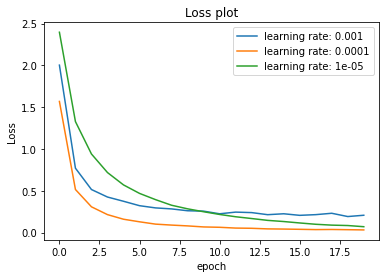

In [48]:
#loss curve for training dataset
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

for learning_rate in hyper_parameters["learning_rate"]:
    plt.plot(epochs,train_loss_hyper_parameters[f'lr{learning_rate}'],label=f'learning rate: {learning_rate}')
    
plt.legend(loc="upper right")
plt.savefig('/kaggle/working/Train_Loss_Plot_PlantVillage-Resnet-LR')
plt.show()

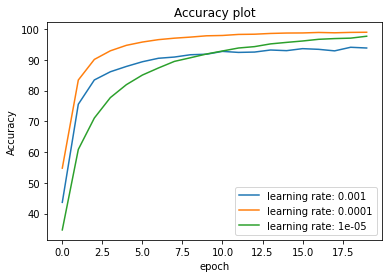

In [17]:
#accuracy curve for training dataset
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

for learning_rate in hyper_parameters["learning_rate"]:
    plt.plot(epochs,train_acc_hyper_parameters[f'lr{learning_rate}'],label=f'learning rate: {learning_rate}')
    
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/Train_Accurary_Plot_PlantVillage-Resnet-LR')
plt.show()

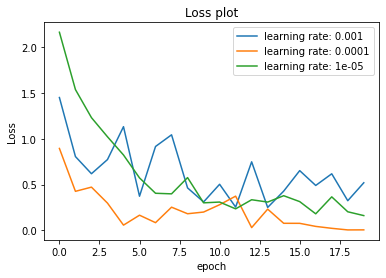

In [50]:
#loss curve for validation dataset
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

for learning_rate in hyper_parameters["learning_rate"]:
    plt.plot(epochs,validation_loss_hyper_parameters[f'lr{learning_rate}'],label=f'learning rate: {learning_rate}')
    
plt.legend(loc="upper right")
plt.savefig('/kaggle/working/Validation_Loss_Plot_PlantVillage-Resnet-LR')
plt.show()

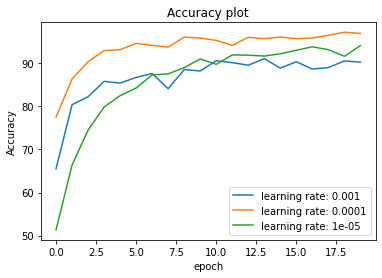

In [51]:
#accuracy curve for validation dataset
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

for learning_rate in hyper_parameters["learning_rate"]:
    plt.plot(epochs,validation_acc_hyper_parameters[f'lr{learning_rate}'],label=f'learning rate: {learning_rate}')
    
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/Validation_Accurary_Plot_PlantVillage-Resnet-LR')
plt.show()

In [ ]:
## batch size hyperparameter

In [42]:
learning_rate = 0.001

for batch_size in hyper_parameters["batch_size"]:
    print(f'Results of the batch size = {batch_size}')
    model = None
    model = getModel()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Load data to DataLoaders for training, validation and test
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size, num_workers=2, pin_memory=True)
    test_dataloader = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)
    
    accuracy_train, accuracy_validation, loss_train, loss_validation, model = train(num_epochs, model, train_dataloader, validation_dataloader, criterion, optimizer)
    aggregate_validation_accuracy = validation_accuracy_calculator(model, validation_dataloader)
    aggregate_test_accuracy = test_accuracy_calculator(model, validation_dataloader)
    
    train_loss_hyper_parameters[f'b{batch_size}'] = loss_train
    train_acc_hyper_parameters[f'b{batch_size}'] = accuracy_train
    validation_loss_hyper_parameters[f'b{batch_size}'] = loss_validation
    validation_acc_hyper_parameters[f'b{batch_size}'] = accuracy_validation
    aggregate_validation_accuracies[f'b{batch_size}'] = aggregate_validation_accuracy
    test_accuracies[f'b{batch_size}'] = aggregate_test_accuracy

Results of the batch size = 8
8
Device: cuda:0
Epoch [1/20], Loss: 2.4717, Accuracy: 32.36%
Epoch [1/20], Loss: 2.1218, Validation Accuracy: 45.54%
Epoch [2/20], Loss: 1.4257, Accuracy: 55.90%
Epoch [2/20], Loss: 1.6490, Validation Accuracy: 61.77%
Epoch [3/20], Loss: 1.1776, Accuracy: 63.36%
Epoch [3/20], Loss: 1.0023, Validation Accuracy: 61.33%
Epoch [4/20], Loss: 1.0156, Accuracy: 67.41%
Epoch [4/20], Loss: 1.4567, Validation Accuracy: 68.66%
Epoch [5/20], Loss: 0.9464, Accuracy: 70.02%
Epoch [5/20], Loss: 1.4533, Validation Accuracy: 68.23%
Epoch [6/20], Loss: 0.8871, Accuracy: 71.96%
Epoch [6/20], Loss: 2.5734, Validation Accuracy: 70.09%
Epoch [7/20], Loss: 0.8384, Accuracy: 73.43%
Epoch [7/20], Loss: 1.4083, Validation Accuracy: 66.11%
Epoch [8/20], Loss: 0.7798, Accuracy: 75.17%
Epoch [8/20], Loss: 1.1526, Validation Accuracy: 74.88%
Epoch [9/20], Loss: 0.7473, Accuracy: 76.55%
Epoch [9/20], Loss: 1.6227, Validation Accuracy: 72.34%
Epoch [10/20], Loss: 0.7257, Accuracy: 77.08

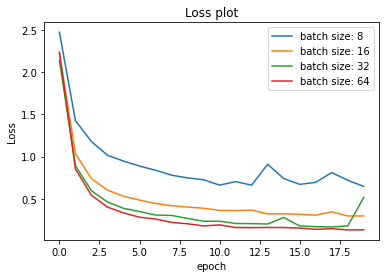

In [57]:
#loss curve for training dataset
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

for batch_size in hyper_parameters["batch_size"]:
    plt.plot(epochs,train_loss_hyper_parameters[f'b{batch_size}'],label=f'batch size: {batch_size}')
    
plt.legend(loc="upper right")
plt.savefig('/kaggle/working/Train_Loss_Plot_PlantVillage-Resnet-BatchSize')
plt.show()

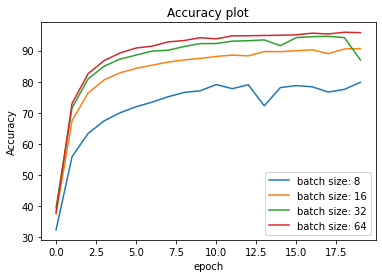

In [23]:
#accuracy curve for training dataset
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

for batch_size in hyper_parameters["batch_size"]:
    plt.plot(epochs,train_acc_hyper_parameters[f'b{batch_size}'],label=f'batch size: {batch_size}')
    
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/Train_Accuracy_Plot_PlantVillage-Resnet-BatchSize')
plt.show()

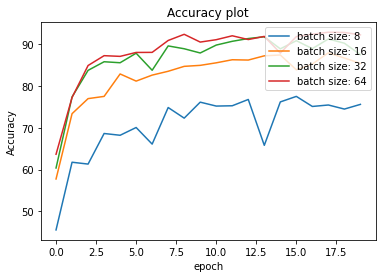

In [58]:
#accuracy curve for validation dataset
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

for batch_size in hyper_parameters["batch_size"]:
    plt.plot(epochs,validation_acc_hyper_parameters[f'b{batch_size}'],label=f'batch size: {batch_size}')
    
plt.legend(loc="upper right")
plt.savefig('/kaggle/working/Validation_Accuracy_Plot_PlantVillage-Resnet-BatchSize')
plt.show()